# Imports

In [172]:
from concurrent.futures import (
    ThreadPoolExecutor,
    as_completed,
)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import os

# Constants

In [2]:
BASE_DIR = os.path.dirname(os.path.abspath(""))
DATASET_NAME = "Agriculture-Vision-2021/_dataset"
BASE_DIR, DATASET_NAME

('/mnt/d/AgriNet-Research/agrinet/datasets',
 'Agriculture-Vision-2021/_dataset')

In [3]:
dataset_path = os.path.join(BASE_DIR, DATASET_NAME)
dataset_train_path = os.path.join(dataset_path, "train")
dataset_val_path = os.path.join(dataset_path, "val")
dataset_test_path = os.path.join(dataset_path, "test")
dataset_train_path

'/mnt/d/AgriNet-Research/agrinet/datasets/Agriculture-Vision-2021/_dataset/train'

In [4]:
LABELS = {
    0: "drydown",
    1: "nutrient_deficiency",
    2: "weed_cluster",
    3: "water",
    4: "endrow",
    5: "double_plant",
    6: "waterway",
    7: "storm_damage",
    8: "planter_skip",
}

# Verify White Pixel Presence in Label Masks

## Utils:

In [5]:
def check_pixels(image_array: np.ndarray, check_for_pixels: int) -> bool:
    return np.any(image_array == check_for_pixels)

def is_label_mask(filepath: str, *, check_for_pixels: int = 255) -> bool:
    try:
        img = Image.open(filepath).convert("L")
        return check_pixels(image_array=np.array(img), check_for_pixels=check_for_pixels)
    except FileNotFoundError:
        # Return False if the file doesnt exist
        return False


def process_label_mask(
    filename: str,
    labels_path: str,
    *,
    ext: str = ".png"
) -> list[int]:
    return [
        1 if is_label_mask(os.path.join(labels_path, label_name, f"{filename}{ext}")) else 0
        for label_name in LABELS.values()
    ]


def process_label_masks_concurrent(
    target_images_paths: list[str],
    labels_path: str,
    *,
    ext: str = ".png",
    max_workers: int = None
) -> pd.DataFrame:
    max_workers = max_workers or cpu_get_max_workers()
    data = []
    columns = ["ID"] + list(LABELS.values())

    def process_single(filepath: str):
        filename, _ = os.path.splitext(os.path.basename(filepath))
        label_results = process_label_mask(
            filename=filename,
            labels_path=labels_path,
            ext=ext
        )
        return [filename] + label_results

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single, fp): fp for fp in target_images_paths}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing masks", unit="file"):
            data.append(future.result())

    return pd.DataFrame(data, columns=columns)


def cpu_get_max_workers() -> int:
    return os.cpu_count() or 1


def get_filepaths(path: str, *, exts: list[str] = []) -> list[str]:
    return [
        os.path.join(path, filename)
        for filename in os.listdir(path)
        if not exts or os.path.splitext(filename)[1] in exts
    ]

In [6]:
def _test():
    path = os.path.join(dataset_train_path, "labels", "endrow")
    mask1 = os.path.join(path, "2I4YH4WR2_1724-5674-2236-6186.png")
    mask2 = os.path.join(path, "1BFUWHD9T_2585-1539-3097-2051.png")
    assert is_label_mask(mask1) == True
    assert is_label_mask(mask2) == False
    %timeit is_label_mask(mask1)
    print("All test passed")


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test")
except Exception as e:
    print(f"Failed load test: {e}")

7.43 ms ± 245 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
All test passed


In [7]:
def _test():
    limit = 10
    exts = [".jpg",]
    path = os.path.join(dataset_train_path, "images", "rgb")
    target_images_paths = get_filepaths(path, exts = exts)[:limit]
    labels_path = os.path.join(dataset_train_path, "labels")
    
    df = process_label_masks_concurrent(
        target_images_paths = target_images_paths,
        labels_path = labels_path,
    )
    print(df.head())


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test")
except Exception as e:
    print(f"Failed load test: {e}")

Processing masks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.77file/s]

                                 ID  drydown  nutrient_deficiency  \
0     11TAQJ6ET_1148-8089-1660-8601        0                    0   
1  11IE4DKTR_11556-9586-12068-10098        0                    0   
2      11TAQJ6ET_1288-961-1800-1473        0                    0   
3      11TAQJ6ET_1749-948-2261-1460        0                    0   
4     11TAQJ6ET_1995-8426-2507-8938        0                    0   

   weed_cluster  water  endrow  double_plant  waterway  storm_damage  \
0             0      0       0             1         0             0   
1             0      0       0             1         0             0   
2             0      0       0             1         0             0   
3             0      0       0             1         0             0   
4             0      0       0             1         0             0   

   planter_skip  
0             0  
1             0  
2             0  
3             0  
4             0  


## Processing:

In [8]:
path = os.path.join(dataset_train_path, "images", "rgb")
target_images_paths = get_filepaths(path)
labels_path = os.path.join(dataset_train_path, "labels")

df = process_label_masks_concurrent(
    target_images_paths = target_images_paths,
    labels_path = labels_path,
)

Processing masks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56944/56944 [10:02<00:00, 94.52file/s]


In [9]:
dn = DATASET_NAME.replace('/','').lower()
filename = f"{dn}_processed_masks.csv"
df.to_csv(filename, index=False)

# EDA

## Load df:

In [141]:
df = pd.read_csv("agriculture-vision-2021_dataset_processed_masks.csv")
label_columns = df.columns[1:]  # Exclude ID
label_counts

drydown                16806
nutrient_deficiency    13308
weed_cluster           11111
double_plant            6234
endrow                  4481
waterway                3899
planter_skip            2599
water                   2155
storm_damage             356
dtype: int64

In [142]:
df.head()

,ID,drydown,nutrient_deficiency,weed_cluster,water,endrow,double_plant,waterway,storm_damage,planter_skip
0,11TAQJ6ET_1995-8426-2507-8938,0,0,0,0,0,1,0,0,0
1,11IE4DKTR_6121-684-6633-1196,0,0,0,0,0,1,0,0,0
2,11TAQJ6ET_1124-8510-1636-9022,0,0,0,0,0,1,0,0,0
3,11TAQJ6ET_1567-8177-2079-8689,0,0,0,0,0,1,0,0,0
4,11TAQJ6ET_1749-948-2261-1460,0,0,0,0,0,1,0,0,0


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56944 entries, 0 to 56943
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   56944 non-null  object
 1   drydown              56944 non-null  int64 
 2   nutrient_deficiency  56944 non-null  int64 
 3   weed_cluster         56944 non-null  int64 
 4   water                56944 non-null  int64 
 5   endrow               56944 non-null  int64 
 6   double_plant         56944 non-null  int64 
 7   waterway             56944 non-null  int64 
 8   storm_damage         56944 non-null  int64 
 9   planter_skip         56944 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 4.3+ MB


## Show image by ID

In [184]:
def find_by_path(base_name:str, search_path:str) -> list:
    matching_files = []
    for root, dirs, files in os.walk(search_path):
        for file in files:
            if os.path.splitext(file)[0] == base_name:
                matching_files.append(os.path.join(root, file))
    return matching_files


def show_image_by_id(image_id: str, search_path: str, *, max_columns:int = 3) -> None:
    matches = find_by_path(base_name=image_id, search_path=search_path)
    if not(matches): return
    
    # Calculate grid size
    n_images = len(matches)
    n_cols = min(max_columns, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_images > 1 else [axes]  # Handle single image case
    
    for ax, img_path in zip(axes, matches):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        p = os.path.basename(os.path.dirname(img_path))
        f = os.path.basename(img_path)
        ax.set_title(f'{p}/{f}')
    
    # Hide any extra axes if the grid is larger than the number of images
    for ax in axes[len(matches):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

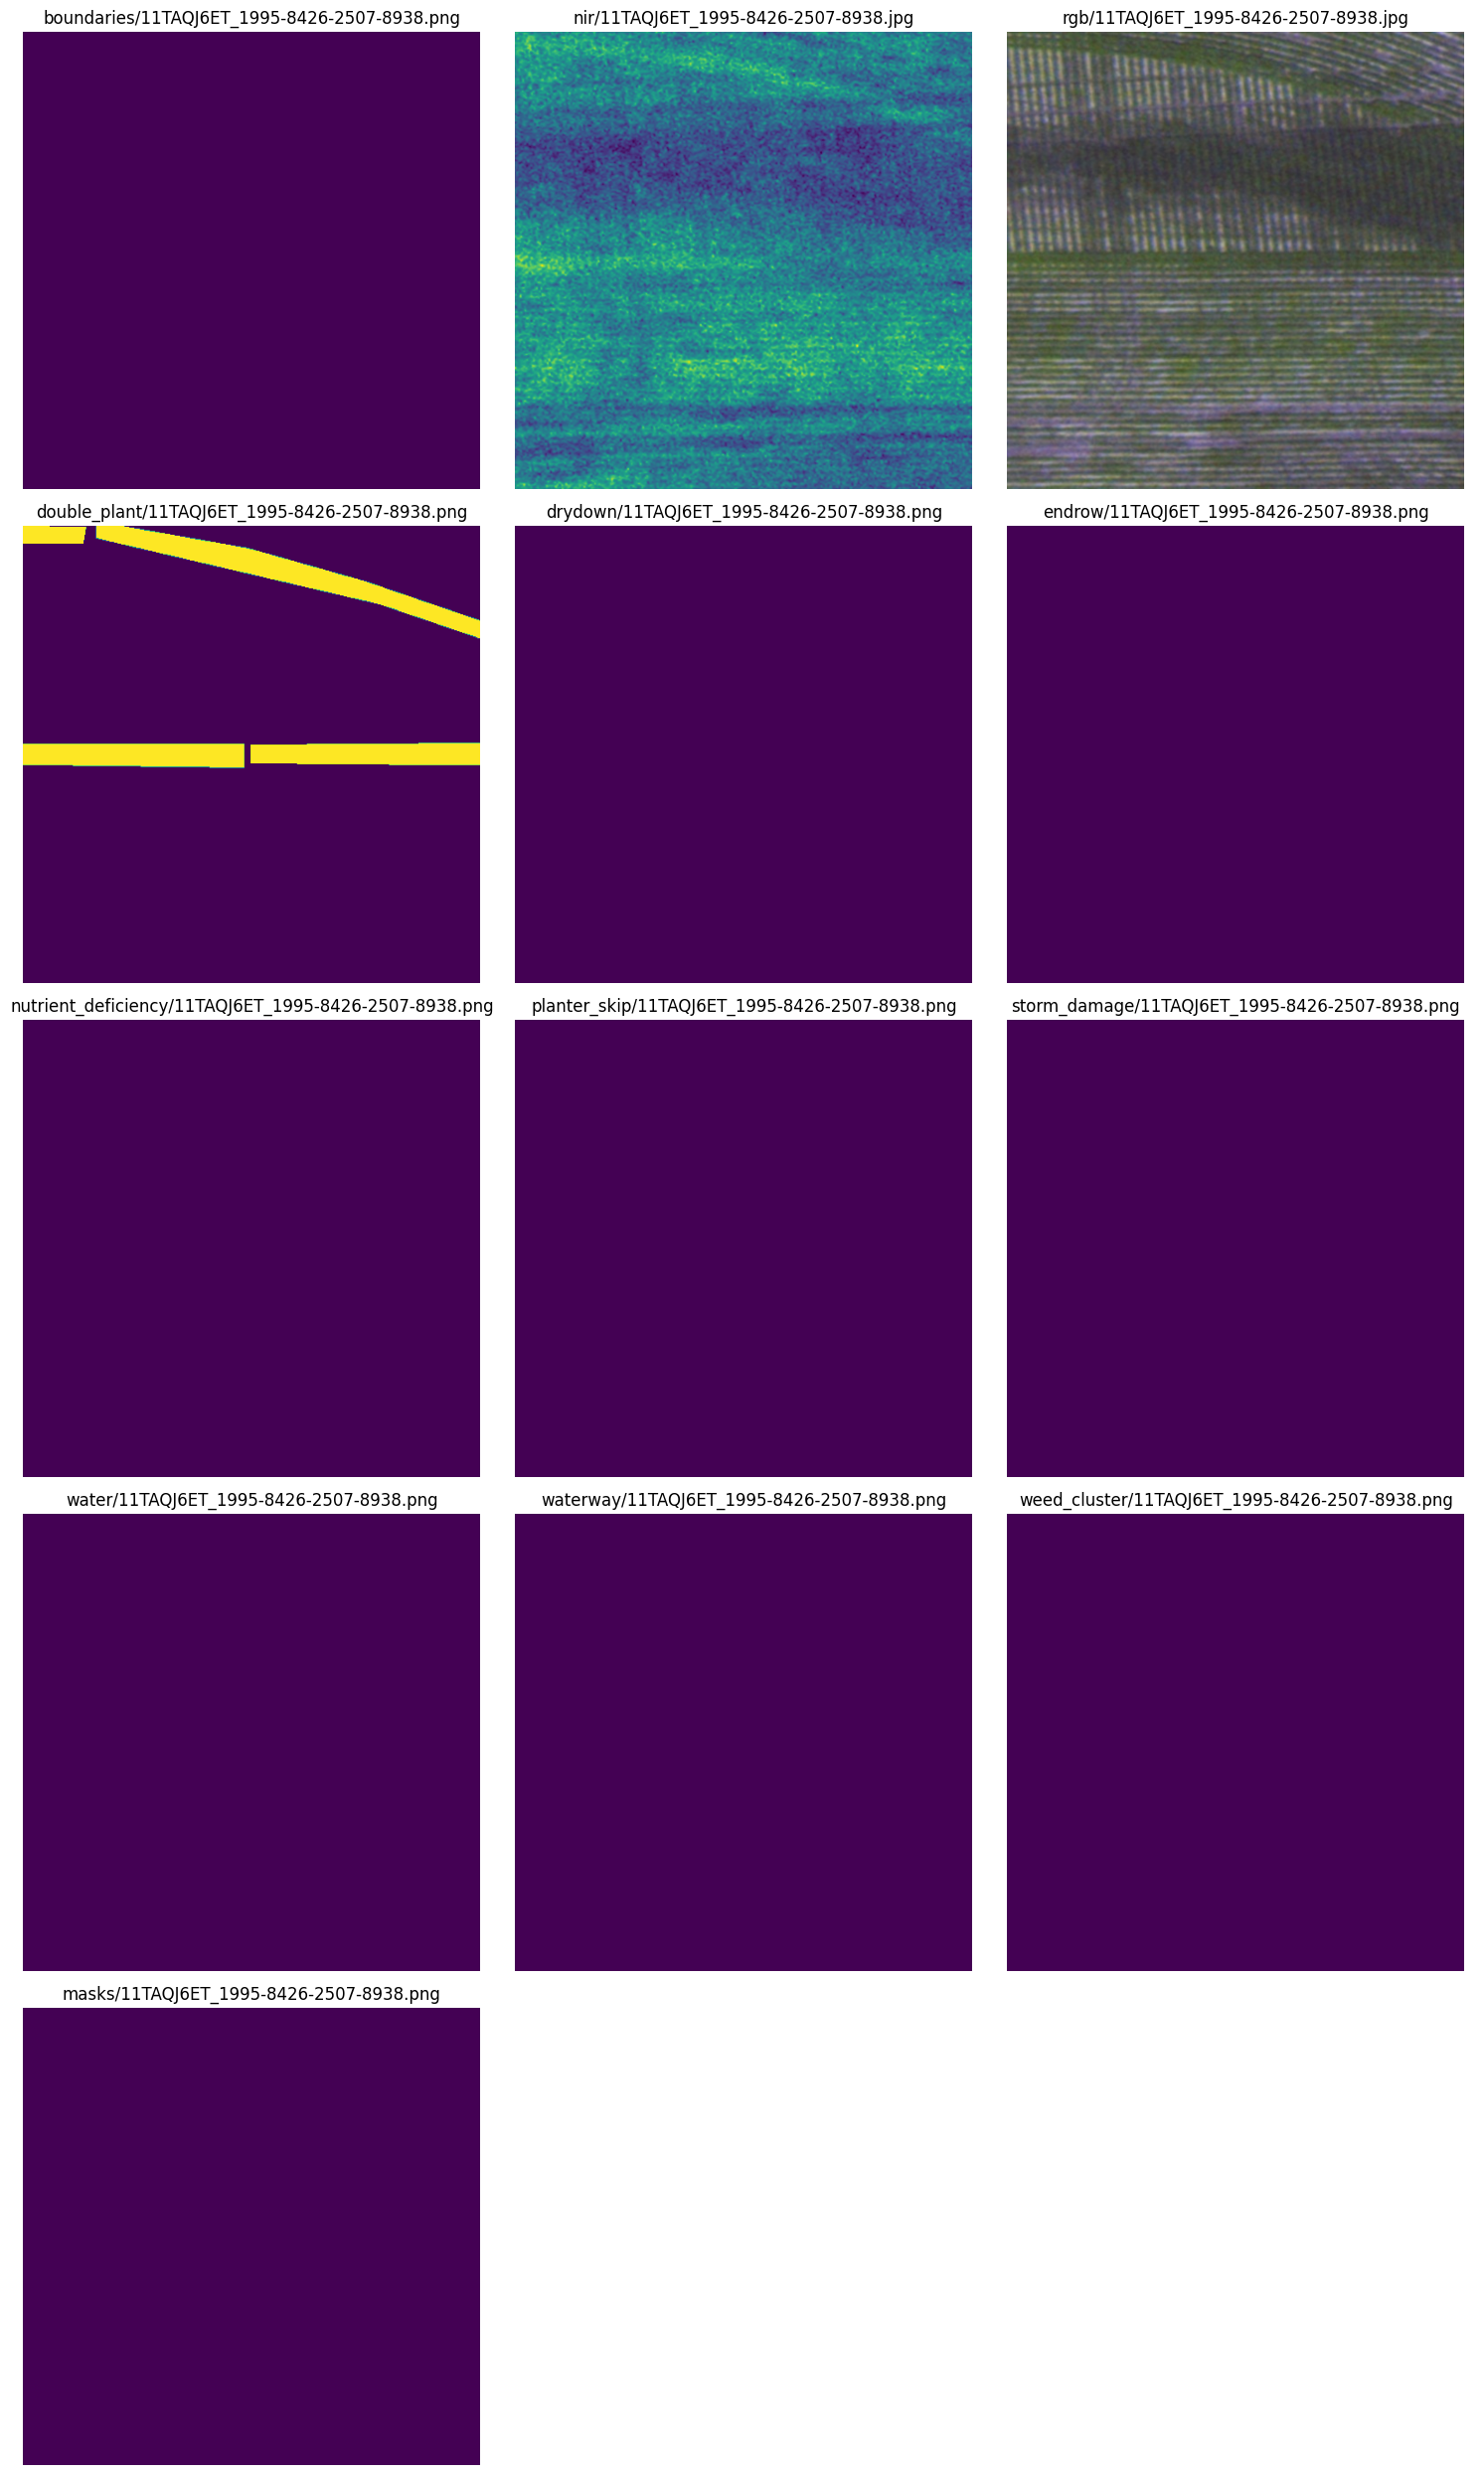

In [189]:
def _test():
    image_id = "11TAQJ6ET_1995-8426-2507-8938"
    show_image_by_id(
        image_id=image_id, 
        search_path=dataset_train_path,
    )


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test")
except Exception as e:
    raise e
    print(f"Failed load test: {e}")

## Label Counts:

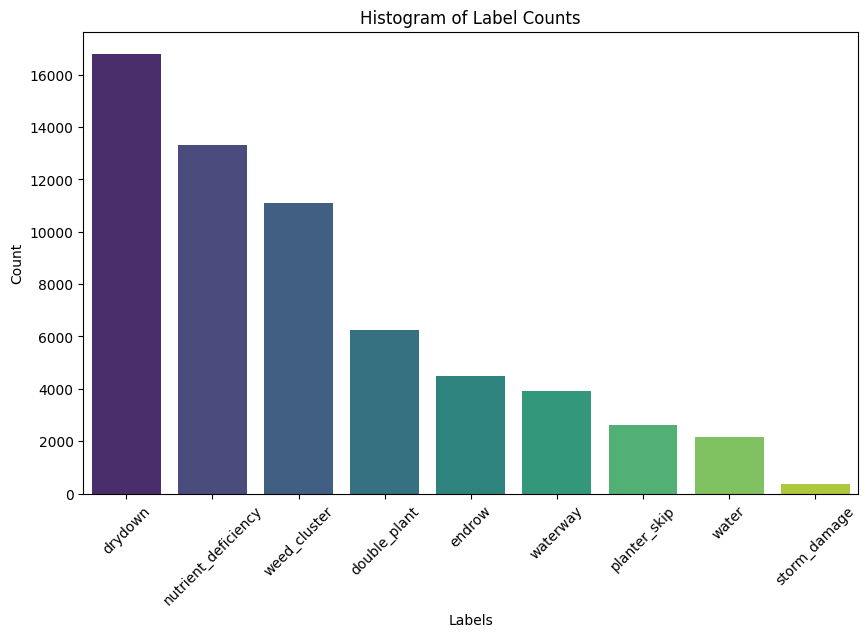

In [144]:
label_counts = df[label_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    dodge=False,
    palette="viridis",
    legend=False,
)
plt.title("Histogram of Label Counts")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Number of Classes on Image:

In [145]:
df["num_classes"] = df[label_columns].sum(axis=1)

num_classes_distribution = df["num_classes"].value_counts().sort_index().to_dict()
print(num_classes_distribution)

{1: 53356, 2: 3182, 3: 395, 4: 11}


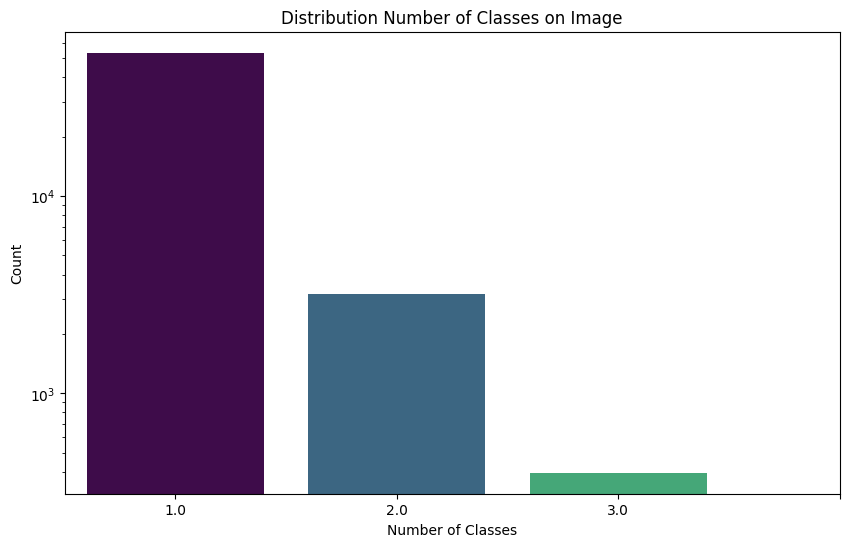

In [146]:
max_classes = df["num_classes"].max()
filtered_df = df[df["num_classes"] < max_classes]

plt.figure(figsize=(10, 6))
sns.countplot(
    data=filtered_df,
    x="num_classes",
    hue=df['num_classes'],
    palette='viridis',
    legend=False,
)
plt.title('Distribution Number of Classes on Image')
plt.xlabel('Number of Classes')
plt.ylabel('Count')
plt.yscale('log')
plt.xticks(range(max_classes))
plt.show()

## Max Number of Classes on Image:

In [147]:
df.sort_values(by='num_classes', ascending=False).head(20)

,ID,drydown,nutrient_deficiency,weed_cluster,water,endrow,double_plant,waterway,storm_damage,planter_skip,num_classes
5928,61JZ66TVX_1919-3384-2431-3896,0,0,1,1,1,1,0,0,0,4
28301,HWGDLXCLT_764-491-1276-1003,0,0,1,0,1,1,0,0,1,4
10376,8NC1KY6TB_6496-1994-7008-2506,0,0,1,0,1,1,0,0,1,4
5926,61JZ66TVX_1763-1123-2275-1635,0,0,1,1,1,1,0,0,0,4
5934,61JZ66TVX_2046-1475-2558-1987,0,0,1,1,1,1,0,0,0,4
10365,8NC1KY6TB_5926-8813-6438-9325,0,0,1,0,1,1,0,0,1,4
5923,61JZ66TVX_1685-3304-2197-3816,0,0,1,1,1,1,0,0,0,4
28286,HWGDLXCLT_4369-132-4881-644,0,0,1,0,1,1,0,0,1,4
5939,61JZ66TVX_2223-1293-2735-1805,0,0,1,1,1,1,0,0,0,4
35663,LWJ3IKMP1_9052-3309-9564-3821,0,0,1,0,1,1,0,0,1,4


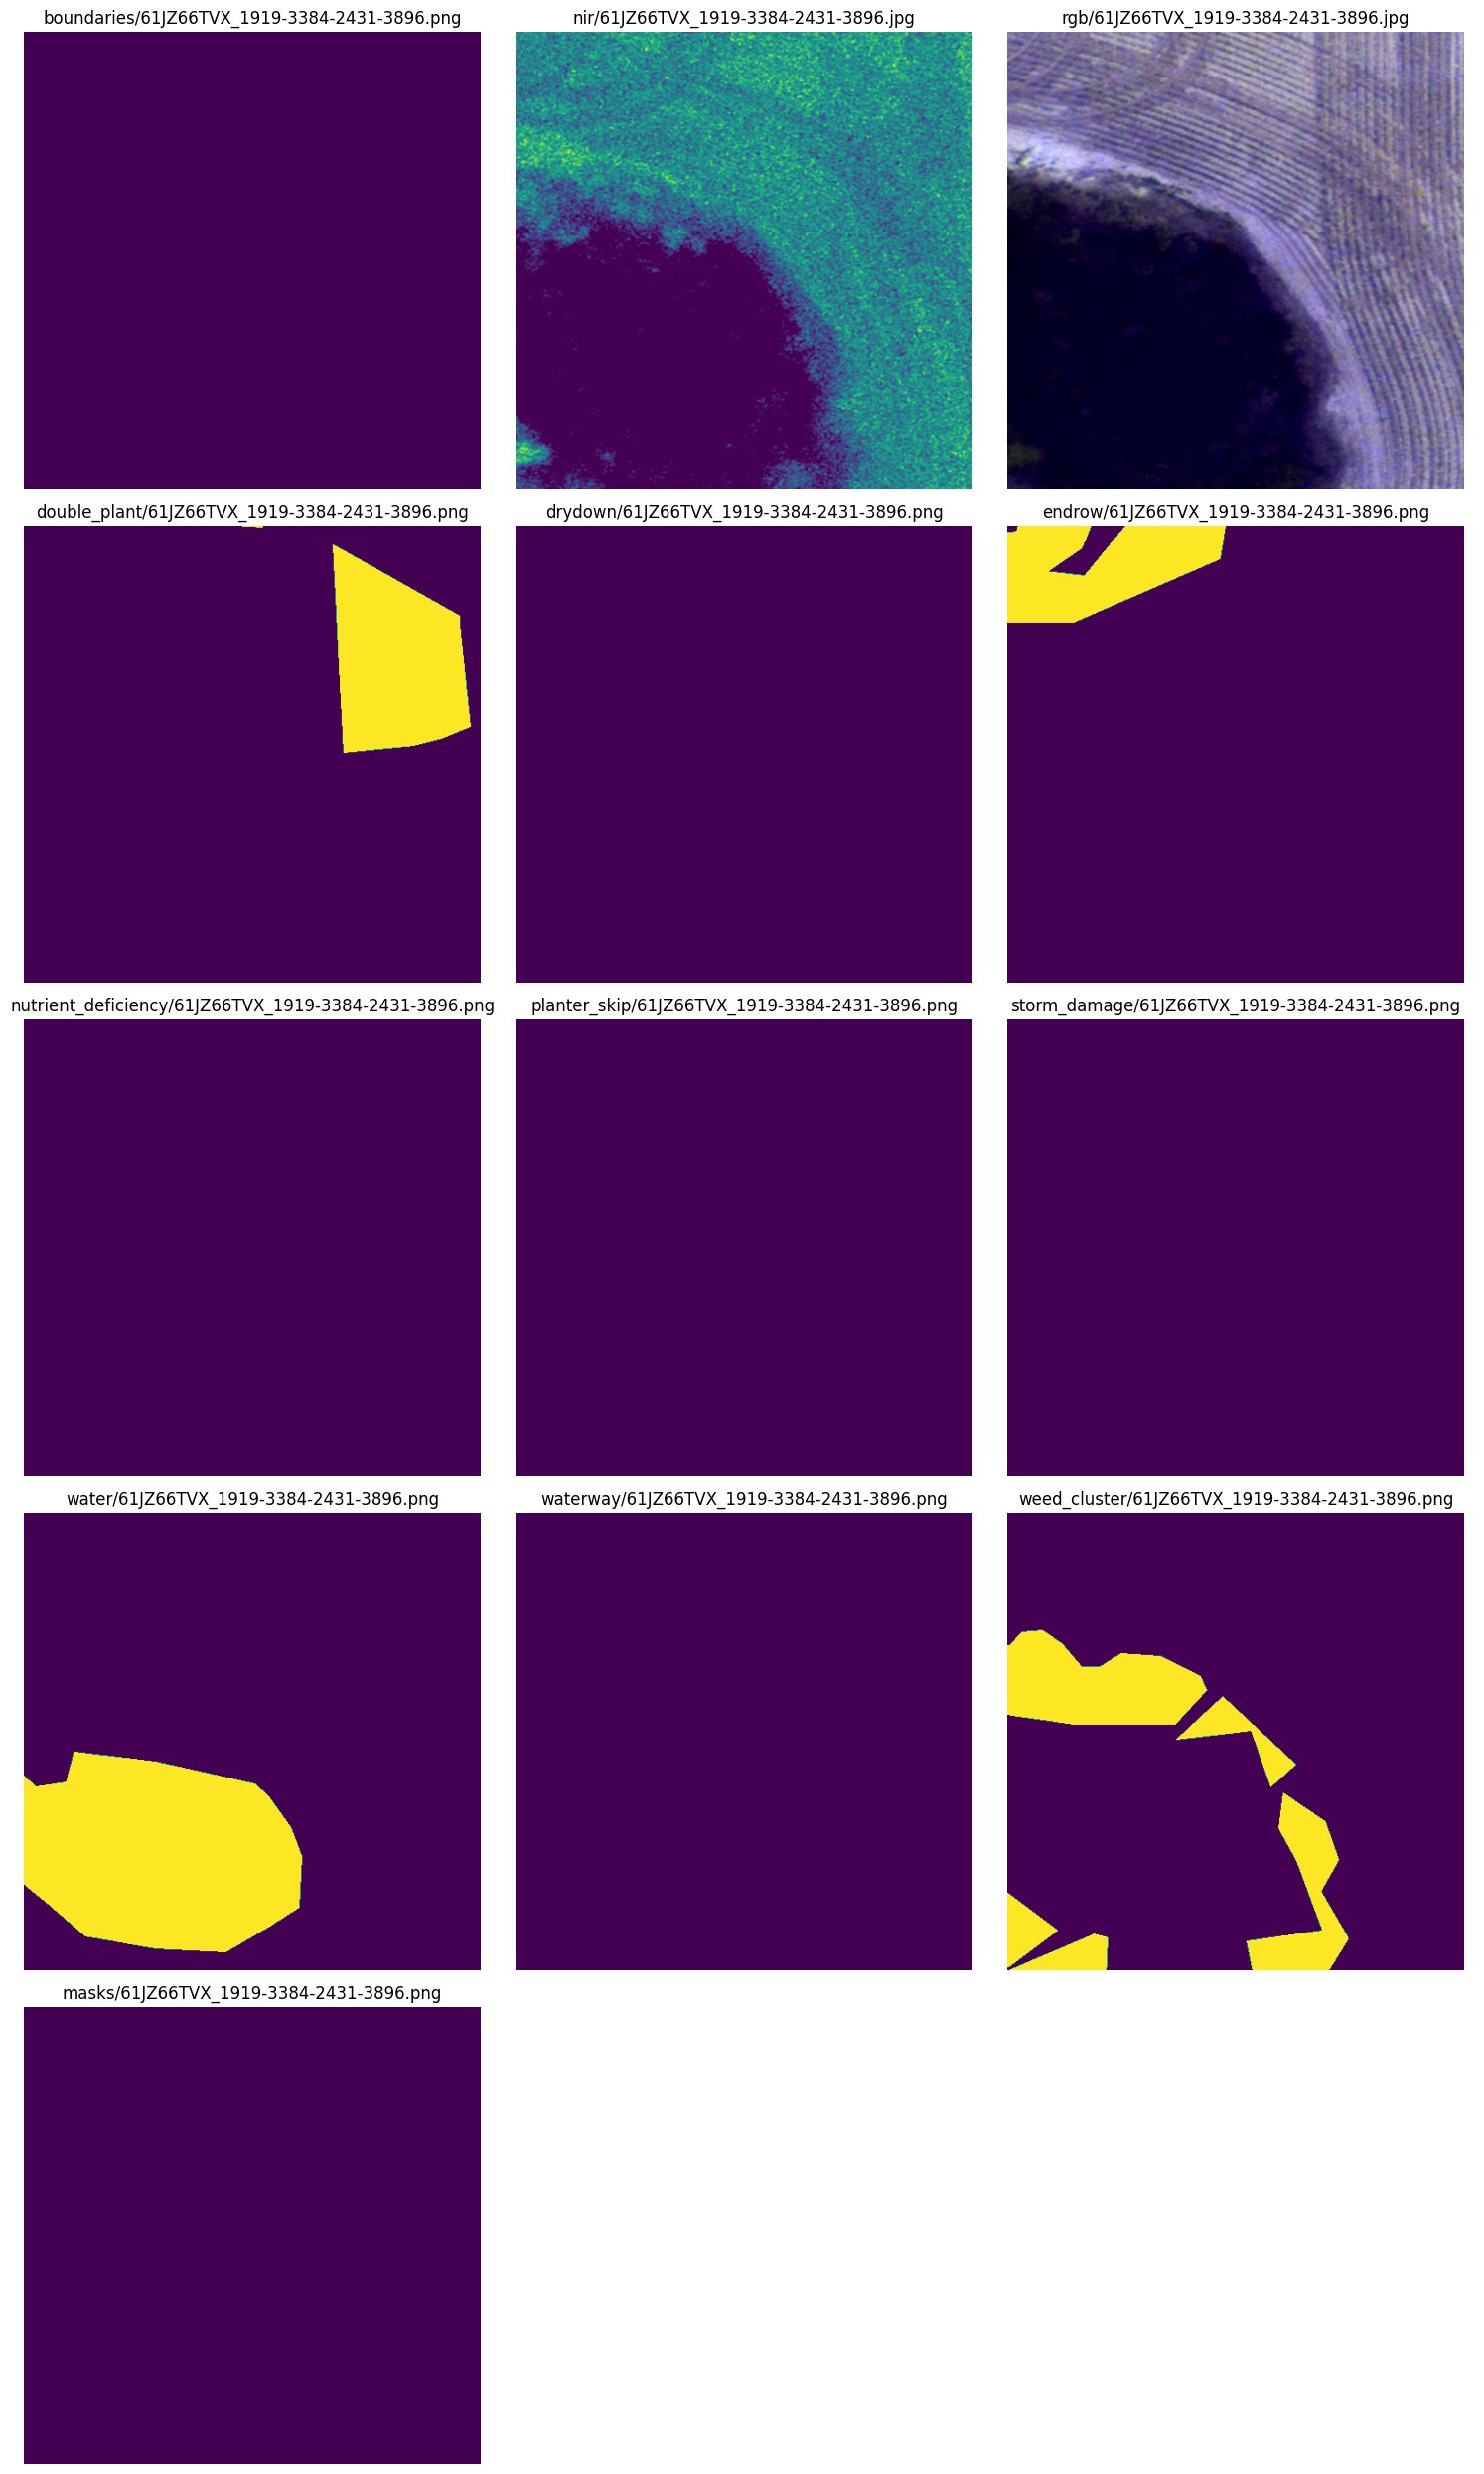

In [191]:
show_image_by_id(
    image_id="61JZ66TVX_1919-3384-2431-3896",
    search_path=dataset_train_path,
)

## Correlation:

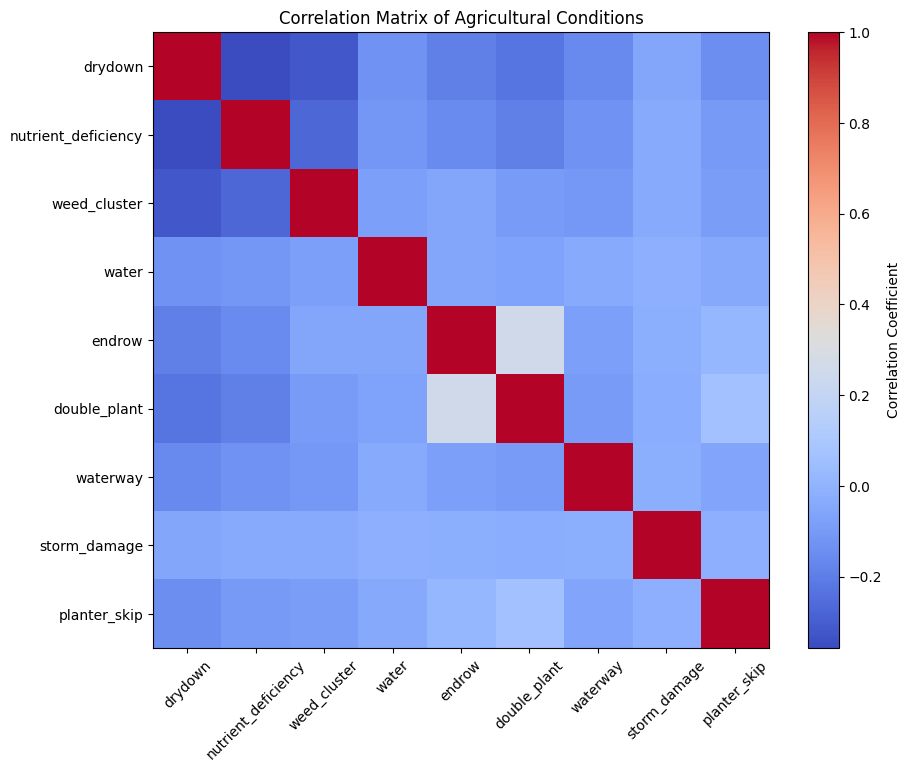

In [148]:
correlations = df[label_columns].corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(label_columns)), label_columns, rotation=45)
plt.yticks(range(len(label_columns)), label_columns)
plt.title('Correlation Matrix of Agricultural Conditions')
plt.show()

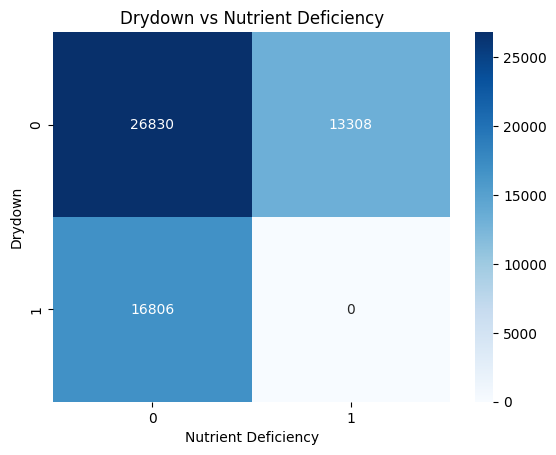

In [149]:
sns.heatmap(pd.crosstab(df['drydown'], df['nutrient_deficiency']), annot=True, fmt='d', cmap='Blues')
plt.title('Drydown vs Nutrient Deficiency')
plt.ylabel('Drydown')
plt.xlabel('Nutrient Deficiency')
plt.show()

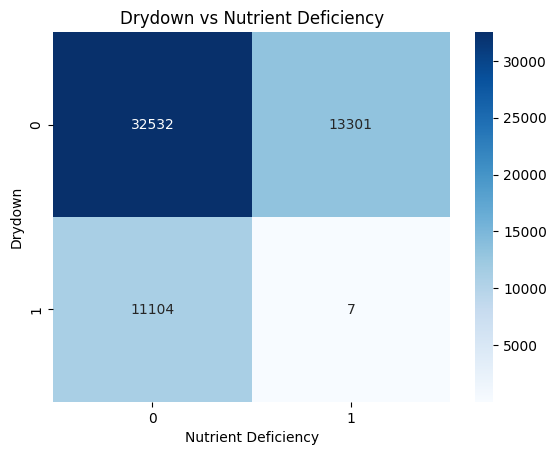

In [150]:
sns.heatmap(pd.crosstab(df['weed_cluster'], df['nutrient_deficiency']), annot=True, fmt='d', cmap='Blues')
plt.title('Drydown vs Nutrient Deficiency')
plt.ylabel('Drydown')
plt.xlabel('Nutrient Deficiency')
plt.show()

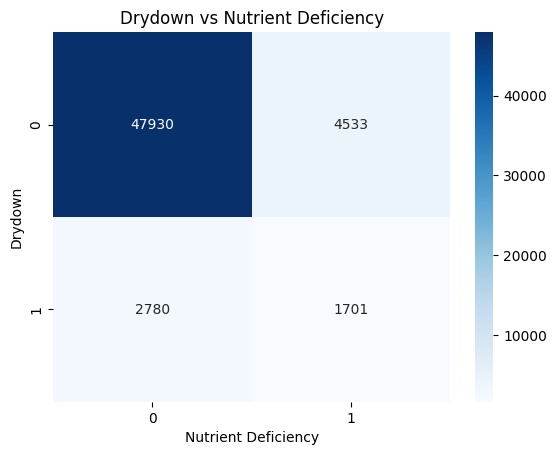

In [151]:
sns.heatmap(pd.crosstab(df['endrow'], df['double_plant']), annot=True, fmt='d', cmap='Blues')
plt.title('Drydown vs Nutrient Deficiency')
plt.ylabel('Drydown')
plt.xlabel('Nutrient Deficiency')
plt.show()

Most conditions show weak correlations, suggesting they occur independently.

Notable moderate correlations exist, such as between nutrient_deficiency and drydown, endrow and double_plant.